In [1]:
import numpy as np
import cv2 as cv
import os
import matplotlib.pyplot as plt

In [2]:
# read the sift vectors from the file
def read_sift_vectors(filename):
    sift_vectors = []
    x = 0
    # parse the file at paranthesis
    with open(filename, 'r') as f:
        # read first line of f
        line = f.readline()
        while line:
            temp_list = []
            line = line.strip()
            if line.startswith('['):
                while(not (line.endswith(']\n') or line.endswith(']'))):
                    temp = line.replace('[', '')
                    temp = temp.replace(']', '')
                    temp = temp.replace('\n', '')
                    if(temp[0] == ' '):
                        temp = temp[1:]
                    temp = temp.split(' ')
                    # remove empty strings
                    temp = list(filter(None, temp))
                    temp_list.extend(float(temp[i]) for i in range(len(temp)))
                    line = f.readline()
                temp = line.replace('[', '')
                temp = temp.replace(']', '') 
                temp = temp.replace('\n', '')
                if(temp[0] == ' '):
                    temp = temp[1:]
                temp = temp.split(' ')
                # remove empty strings
                temp = list(filter(None, temp))
                temp_list.extend(float(temp[i]) for i in range(len(temp)))


            # convert to numpy array
            # parse the list to get the float values
            temp_list = [float(i) for i in temp_list]
            temp_list = np.array(temp_list)
            sift_vectors.append(temp_list)
            line = f.readline()



    return np.array(sift_vectors)

In [29]:
sift_file = './image_words_sift.txt'

# read the sift vectors
sift_vectors = read_sift_vectors(sift_file)

In [26]:
def getFeatureVectors_sift(img, vocabulary):
    features = np.zeros(vocabulary.shape[0])
    sift = cv.SIFT_create()
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    kp = []
    des = []
    k = 60
    for l in range(img.shape[0]//k):
        for j in range(img.shape[1]//k):
            kp_block = sift.detect(gray[l*k:(l+1)*k,j*k:(j+1)*k], None)
            # extract only the strongest keypoints in each block
            kp_block = sorted(kp_block, key=lambda x: -x.response)[:1]
            # if there is no keypoint in the block, take the centre point as the keypoint
            if len(kp_block) == 0:
                kp_block = [cv.KeyPoint(l*k+k/2,j*k+k/2,k)]
            kp_block,des_block = sift.compute(gray[l*k:(l+1)*k,j*k:(j+1)*k],kp_block)

            # find minimum distance between the descriptors of the block and the vocabulary
            features[np.argmin([np.linalg.norm(des_block - v) for v in vocabulary])] += 1

    return features

In [99]:
image = cv.imread('./imgs/25.jpg')

# get the feature vectors
feature_vectors = getFeatureVectors_sift(image, sift_vectors)

In [30]:
k = 60

images = os.listdir("imgs")
max_num = 0
for image in images:
    num = int(image.split(".")[0])
    if num > max_num:
        max_num = num
max_num += 1

sift_features = np.zeros((max_num,(360//k)*(480//k),128))
sift_vectors_all = np.zeros((max_num, sift_vectors.shape[0]))

for image_name in images:
    img = cv.imread("imgs/"+image_name)
    img_num = int(image_name.split(".")[0])
    sift_vectors_all[img_num] = getFeatureVectors_sift(img, sift_vectors)

# davg = np.mean(np.sum(sift_vectors_all, axis=1))

In [31]:
davg = np.mean(np.sum(sift_vectors_all, axis=1), axis = 0)

In [32]:
def tf_score(word, image, k1, b, davg, vocabulary):
    feat = getFeatureVectors_sift(image, vocabulary)
    tf = k1*feat[word] / (feat[word] + k1 * (1 - b + b * (np.sum(feat) / davg)))
    return tf

In [33]:
def idf_score(word, data_folder, sift_all):
    Dj = 0
    for i in range(len(sift_all)):
        if sift_all[i][word] > 0:
            Dj += 1

    D = len(os.listdir(data_folder))

    idf = np.log((D + 1) / (Dj + 0.5))
    return idf

In [35]:
image = cv.imread('./imgs/25.jpg')

In [36]:
tff = tf_score(0, image, 1.2, 0.75, 1, sift_vectors)

In [37]:
tff

0.02696629213483146

In [38]:
idf = idf_score(0, './imgs', sift_vectors_all)

In [39]:
idf

0.33305702247812635

In [40]:
def score(img1, img2, sift_all, vocabulary):
    score = 0
    for i in range(len(vocabulary)):
        score += tf_score(i, img1, 1.2, 0.75, davg, vocabulary) * idf_score(i, './imgs', sift_all) * tf_score(i, img2, 1.2, 0.75, davg, vocabulary) * idf_score(i, './imgs', sift_all)

    return score

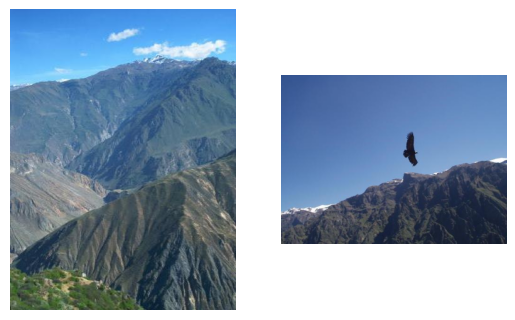

Score for both these images is:  1.0766531123955658


In [41]:
img1 = cv.imread('./imgs/5152.jpg')
img2 = cv.imread('./imgs/5155.jpg')

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

plt.figure()
plt.subplot(121)
plt.imshow(img1)
plt.axis('off')
plt.subplot(122)
plt.imshow(img2)
plt.axis('off')
plt.show()


scr = score(img1, img2, sift_vectors_all, sift_vectors)
print("Score for both these images is: ", scr)

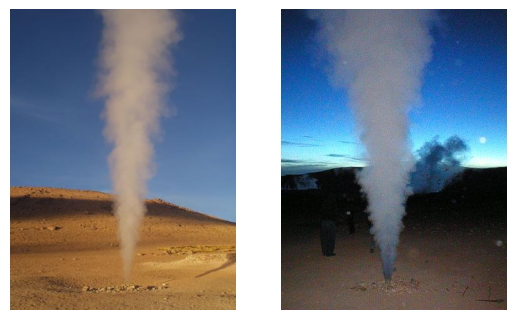

Score for both these images is:  1.0716874197901776


In [42]:
img1 = cv.imread('./imgs/1877.jpg')
img2 = cv.imread('./imgs/1879.jpg')


img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

plt.figure()
plt.subplot(121)
plt.imshow(img1)
plt.axis('off')
plt.subplot(122)
plt.imshow(img2)
plt.axis('off')
plt.show()


scr = score(img1, img2, sift_vectors_all, sift_vectors)
print("Score for both these images is: ", scr)

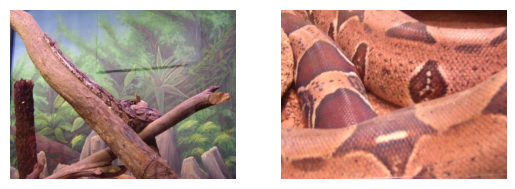

Score for both these images is:  0.5079539701944691


In [43]:
img1 = cv.imread('./imgs/3191.jpg')
img2 = cv.imread('./imgs/3193.jpg')


img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

plt.figure()
plt.subplot(121)
plt.imshow(img1)
plt.axis('off')
plt.subplot(122)
plt.imshow(img2)
plt.axis('off')
plt.show()


scr = score(img1, img2, sift_vectors_all, sift_vectors)
print("Score for both these images is: ", scr)

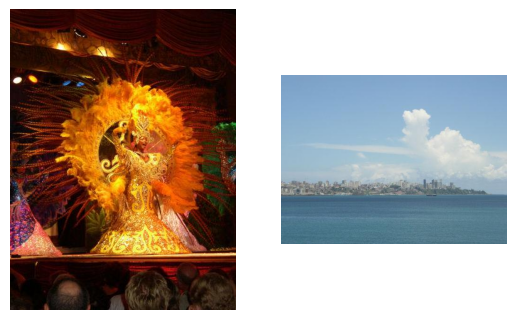

Score for both these images is:  0.22610005938056552


In [44]:
img1 = cv.imread('./imgs/3170.jpg')
img2 = cv.imread('./imgs/3208.jpg')


img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

plt.figure()
plt.subplot(121)
plt.imshow(img1)
plt.axis('off')
plt.subplot(122)
plt.imshow(img2)
plt.axis('off')
plt.show()


scr = score(img1, img2, sift_vectors_all, sift_vectors)
print("Score for both these images is: ", scr)

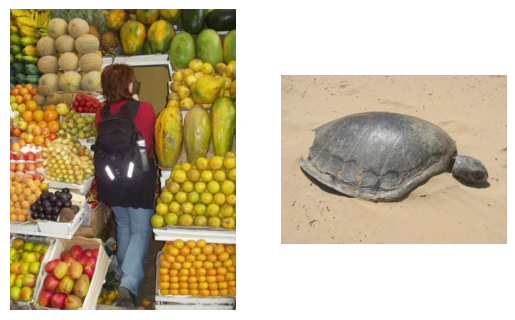

Score for both these images is:  0.41916708268728575


In [45]:
img1 = cv.imread('./imgs/3838.jpg')
img2 = cv.imread('./imgs/3318.jpg')


img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

plt.figure()
plt.subplot(121)
plt.imshow(img1)
plt.axis('off')
plt.subplot(122)
plt.imshow(img2)
plt.axis('off')
plt.show()


scr = score(img1, img2, sift_vectors_all, sift_vectors)
print("Score for both these images is: ", scr)

In [46]:
mstd_vocabulary = read_sift_vectors('./image_words_mstd.txt')

In [47]:
def getMSTDfeatures(img, vocabulary):
    k = 60
    img = img/255
    colors_sum = img[...,0] + img[...,1] + img[...,2]
    r_ratio = img[...,2]/(colors_sum+0.0001)
    g_ratio = img[...,1]/(colors_sum+0.0001)
    norm = colors_sum/3
    features = [0]*vocabulary.shape[0]

    for j in range(img.shape[0]//k):
        for l in range(img.shape[1]//k):
            r_avg = []
            g_avg = []
            norm_avg = []
            
            r_std = []
            g_std = []
            norm_std = []
            r_avg.append(np.mean(r_ratio[j*k:(j+1)*k,l*k:(l+1)*k]))
            g_avg.append(np.mean(g_ratio[j*k:(j+1)*k,l*k:(l+1)*k]))
            norm_avg.append(np.mean(norm[j*k:(j+1)*k,l*k:(l+1)*k]))

            r_std.append(np.std(r_ratio[j*k:(j+1)*k,l*k:(l+1)*k]))
            g_std.append(np.std(g_ratio[j*k:(j+1)*k,l*k:(l+1)*k]))
            norm_std.append(np.std(norm[j*k:(j+1)*k,l*k:(l+1)*k]))

            # reshape the arrays to 1D
            r_avg = np.array(r_avg).reshape(-1)
            g_avg = np.array(g_avg).reshape(-1)
            norm_avg = np.array(norm_avg).reshape(-1)
            r_std = np.array(r_std).reshape(-1)
            g_std = np.array(g_std).reshape(-1)
            norm_std = np.array(norm_std).reshape(-1)
            # hstack the arrays 
            mstd = (np.hstack((r_avg, g_avg, norm_avg, r_std, g_std, norm_std))) 

            features[np.argmin(np.linalg.norm(vocabulary - mstd, axis=1))] += 1

    return features

In [48]:

k = 60

images = os.listdir("imgs")
max_num = 0
for image in images:
    num = int(image.split(".")[0])
    if num > max_num:
        max_num = num
max_num += 1

mstd_features = np.zeros((max_num,(360//k)*(480//k),6))
mstd_vectors_all = np.zeros((max_num, mstd_vocabulary.shape[0]))

for image_name in images:
    img = cv.imread("imgs/"+image_name)
    img_num = int(image_name.split(".")[0])
    mstd_vectors_all[img_num] = getMSTDfeatures(img, mstd_vocabulary)

# davg = np.mean(np.sum(sift_vectors_all, axis=1))

In [49]:
davg = np.mean(np.sum(mstd_vectors_all, axis=1), axis = 0)

In [50]:
def tf_score_MSTD(word, image, k1, b, davg, vocabulary):
    feat = getMSTDfeatures(image, vocabulary)
    tf = k1*feat[word] / (feat[word] + k1 * (1 - b + b * (np.sum(feat) / davg)))
    return tf

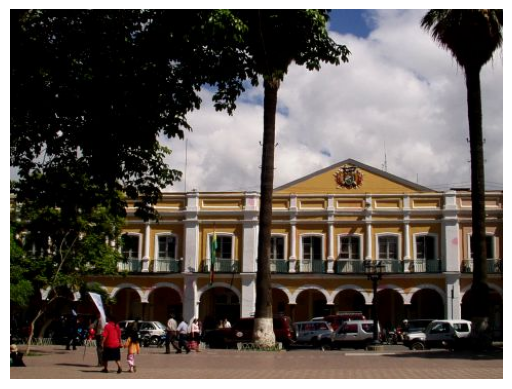

MSTD features:  [1, 0, 0, 5, 0, 3, 2, 0, 0, 0, 11, 2, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 9, 0, 0, 0, 4]
TF score of 4th word:  0.8427055316217935
IDF score of 4th word:  0.5449216459962019


In [51]:
img = cv.imread('./imgs/25.jpg')

feature = getMSTDfeatures(img, mstd_vocabulary)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

tf_img = tf_score_MSTD(3, img, 1.2, 0.8, davg, mstd_vocabulary)
idf_img = idf_score(3, './imgs', mstd_vectors_all)
print('MSTD features: ', feature)
print('TF score of 4th word: ', tf_img)
print('IDF score of 4th word: ', idf_img)

In [52]:
def scoreMSTD(img1, img2, sift_all, vocabulary):
    score = 0
    for i in range(len(vocabulary)):
        score += tf_score_MSTD(i, img1, 1.2, 0.75, davg, vocabulary) * idf_score(i, './imgs', sift_all) * tf_score_MSTD(i, img2, 1.2, 0.75, davg, vocabulary) * idf_score(i, './imgs', sift_all)

    return score

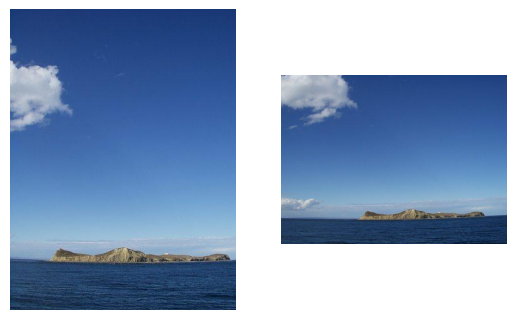

Score for both these images is:  4.294752853620028


In [53]:
img1 = cv.imread('./imgs/3489.jpg')
img2 = cv.imread('./imgs/3490.jpg')

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

plt.figure()
plt.subplot(121)
plt.imshow(img1)
plt.axis('off')
plt.subplot(122)
plt.imshow(img2)
plt.axis('off')
plt.show()

scr = scoreMSTD(img1, img2, mstd_vectors_all, mstd_vocabulary)
print("Score for both these images is: ", scr)

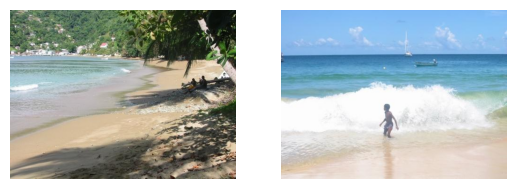

Score for both these images is:  1.5908277782596631


In [54]:
img1 = cv.imread('./imgs/4002.jpg')
img2 = cv.imread('./imgs/4005.jpg')

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

plt.figure()
plt.subplot(121)
plt.imshow(img1)
plt.axis('off')
plt.subplot(122)
plt.imshow(img2)
plt.axis('off')
plt.show()

scr = scoreMSTD(img1, img2, mstd_vectors_all, mstd_vocabulary)
print("Score for both these images is: ", scr)

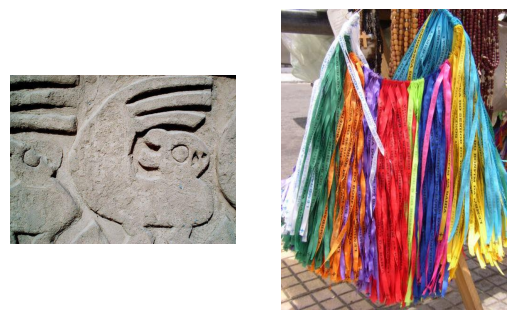

Score for both these images is:  0.9576305280514091


In [55]:
img1 = cv.imread('./imgs/2454.jpg')
img2 = cv.imread('./imgs/3225.jpg')

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

plt.figure()
plt.subplot(121)
plt.imshow(img1)
plt.axis('off')
plt.subplot(122)
plt.imshow(img2)
plt.axis('off')
plt.show()

scr = scoreMSTD(img1, img2, mstd_vectors_all, mstd_vocabulary)
print("Score for both these images is: ", scr)

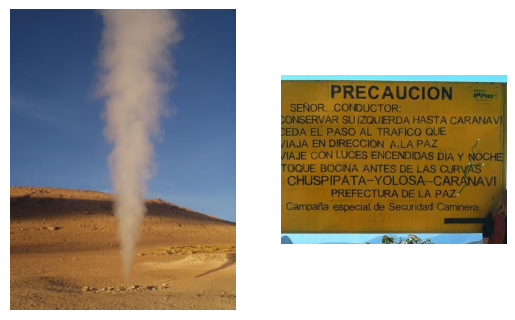

Score for both these images is:  4.716221951995139


In [56]:
img1 = cv.imread('./imgs/1877.jpg')
img2 = cv.imread('./imgs/1764.jpg')

img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

plt.figure()
plt.subplot(121)
plt.imshow(img1)
plt.axis('off')
plt.subplot(122)
plt.imshow(img2)
plt.axis('off')
plt.show()

scr = scoreMSTD(img1, img2, mstd_vectors_all, mstd_vocabulary)
print("Score for both these images is: ", scr)